# Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Implement Stuff from sratch. Use cv2 functions only when numpy implementation can be extremely tedious.***



You will need to use your own image for this assignment, which you need to import into here.
If you cant fetch your image from any APIs that dont need credentials, then :
To preserve an image in Google Colab without a continuous runtime or using Google Drive, you can use base64 string encoding of images ( its really simple )

First, begin by normally uploading the image into the contents folders as you normally do in colab or fetch it using Drive or any API.

To get the base64 string :
```
import base64
with open("your_image.jpg", "rb") as img_file:
    print(base64.b64encode(img_file.read()).decode())
```

Note that the base64 string is a very long string, click on the three dot icon to the left of the current code cell and click on <code> Copy Cell Output </code> to easily copy it to your clipboard.

Then, to embed the string into your Jupyter Notebook :
```
from PIL import Image
import io
import base64
import matplotlib.pyplot as plt
import numpy as np

# PASTE BASE64 STRING HERE
base64_image = "iVBORw0K..."  # long base64 string

img_data = base64.b64decode(base64_image)
img = Image.open(io.BytesIO(img_data))

plt.imshow(img)
plt.axis("off")
```
The string is really long so, use a multiline string in python ( syntax : """ """ )

Otherwise, you can also choose to use any API ( try researching on https://picsum.photos/ )

## Part A

### Load your image

1. Display it in RGB

2. Convert to grayscale ( use NumPy to calculate aggregates using the weighted sum formula )

3. Use the cvtColor function to do the same and compare results

3. Print the array shapes of both the RGB and grayscale images

4. Print a few pixel values of both

( Do you notice the difference that number of channels created on the array shape ?? )

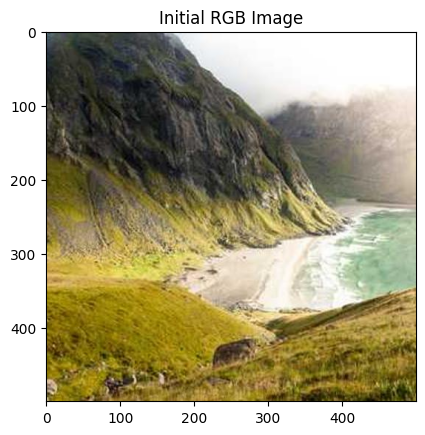

In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

def download_image(seed_val):
    url = f"https://picsum.photos/seed/{seed_val}/500"
    resp = requests.get(url)
    # converting from PIL to a format OpenCV/Numpy likes
    img = Image.open(BytesIO(resp.content))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Part A,,,, loading the first image
raw_bgr = download_image(101)
img_rgb = cv2.cvtColor(raw_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Initial RGB Image")
plt.show()

In [47]:
# A2. converting to grayscale manually using the standard luminosity formula
# formula: (0.299*R + 0.587*G + 0.114*B)

weights = [0.299, 0.587, 0.114]
gray_manual = np.array(np.dot(img_rgb[..., :3], weights), dtype=np.uint8)

# A3. Now let OpenCV do it for comparison

gray_cv2 = cv2.cvtColor(raw_bgr, cv2.COLOR_BGR2GRAY)

# A4 & A5. Checking the shapes and some actual pixel values

print("--- Array Shapes ---")
print(f"Original RGB: {img_rgb.shape}")
print(f"Grayscale:    {gray_manual.shape}")

print("\n--- Pixel Value Comparison (First 3x3 block) ---")
print("Manual conversion:\n", gray_manual[:3, :3])
print("OpenCV conversion:\n", gray_cv2[:3, :3])

# Observation: the shape difference is basically the 3rd dimension.
# RGB is a 3D cube (H, W, Channels), whereas Gray is just a 2D matrix.

--- Array Shapes ---
Original RGB: (500, 500, 3)
Grayscale:    (500, 500)

--- Pixel Value Comparison (First 3x3 block) ---
Manual conversion:
 [[218 213 197]
 [213 199 176]
 [186 162 130]]
OpenCV conversion:
 [[219 214 197]
 [214 200 176]
 [187 163 130]]


## Part B
### B1. Compute the FFT of the grayscale image ( use NumPy )
Steps:
1. <code>np.fft.fft2</code>
2. <code>np.fft.fftshift</code>
3. Store as <code>fshift</code>

### B2. Compute magnitude, phase and display Magnitude Spectrum

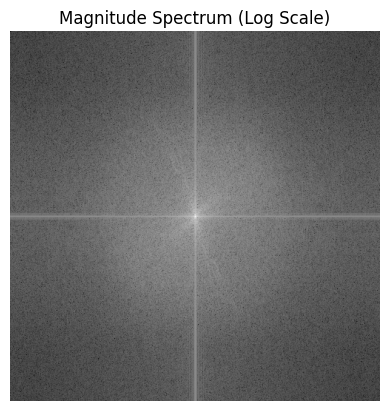

In [48]:
# B1. Calculating the 2D FFT
# I'll use fftshift so the 0-frequency component is in the middle of the plot
dft = np.fft.fft2(gray_manual)
fshift = np.fft.fftshift(dft)

# B2. Getting Magnitude and Phase
mag_spectrum = np.abs(fshift)
phase_spectrum = np.angle(fshift)

# Displaying the spectrum - using log because the center is usually way too bright
plt.imshow(np.log(1 + mag_spectrum), cmap='gray')
plt.title("Magnitude Spectrum (Log Scale)")
plt.axis('off')
plt.show()

## Part C
### C1. Create 3 LPF masks

Radii of filter: 10, 30, 80 (or image-size dependent, mention if you change)

For each:

1. Create a mask

2. Apply to <code>fshift</code>

3. Reconstruct using <code>ifftshift + ifft2</code>

4. Show blur levels increasing as radius decreases ( think why and write reason in code comment )

### C2. Create HPF mask

1. Apply

2. Reconstruct

### C3. Create a square LPF mask
Keep side of square as 50. The square will be at the center of the filter.
Apply, Recontruct and show the output.

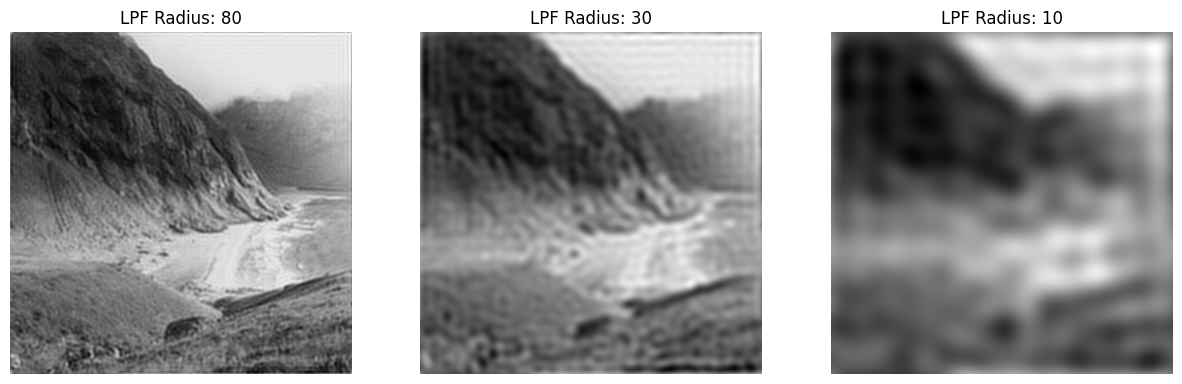

In [49]:
rows, cols = gray_manual.shape
crow, ccol = rows // 2 , cols // 2 # finding the center

def get_low_pass_result(radius):
    # Creating a black image as a base
    mask = np.zeros((rows, cols), np.uint8)
    # Drawing a white circle in the center
    cv2.circle(mask, (ccol, crow), radius, 1, -1)

    # Apply mask and invert
    filtered_fshift = fshift * mask
    f_ishift = np.fft.ifftshift(filtered_fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)

# C1. Testing radii 10, 30, and 80
radii = [80, 30, 10]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, r in enumerate(radii):
    res = get_low_pass_result(r)
    axes[i].imshow(res, cmap='gray')
    axes[i].set_title(f"LPF Radius: {r}")
    axes[i].axis('off')

# The image gets blurrier as the radius gets smaller.
# This is because we're throwing away the "fast" changing data (edges) and only keeping the "slow" changing data (broad colors/blobs).

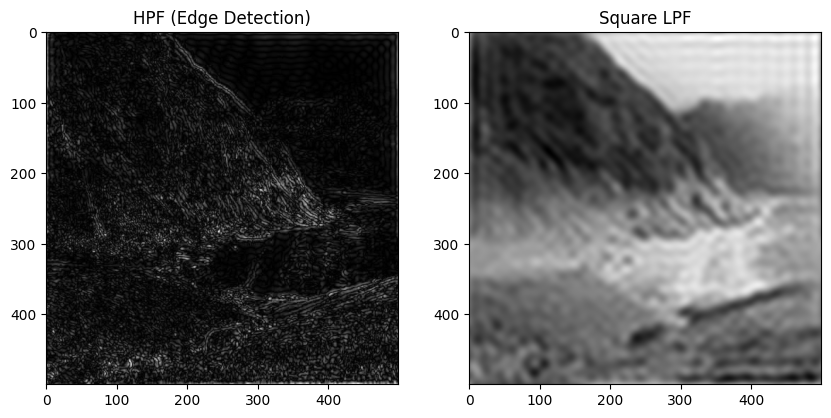

In [50]:
# C2. High Pass Mask (Blocking the center)
hpf_mask = np.ones((rows, cols), np.uint8)
cv2.circle(hpf_mask, (ccol, crow), 30, 0, -1)
hpf_res = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift * hpf_mask)))

# C3. Square LPF Mask
sq_mask = np.zeros((rows, cols), np.uint8)
s = 50 # side length
sq_mask[crow - s//2 : crow + s//2, ccol - s//2 : ccol + s//2] = 1
sq_res = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift * sq_mask)))

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(hpf_res, cmap='gray'), plt.title("HPF (Edge Detection)")
plt.subplot(122), plt.imshow(sq_res, cmap='gray'), plt.title("Square LPF")
plt.show()

## Part D

###D1. Phase-only reconstruction

Use: <code>phase_only = fshift / np.abs(fshift)</code>

1. Reconstruct and display.
2. Also in code comments, mention the differnce between this code line and the one in the lecture : <code>np.angle(f_shift)</code>
3. Try recontruction from <code>np.angle(f_shift)</code> once and explain your output in code comments.



###D2. Magnitude-only reconstruction

Use: <code>mag_only = np.abs(fshift)</code>

1. Reconstruct and display.
2. Take a guess for the role of logarithm in Magnitude Spectrum. Why does this look different than what Magnitude Spectrum looked like ? Mention in code comments again.

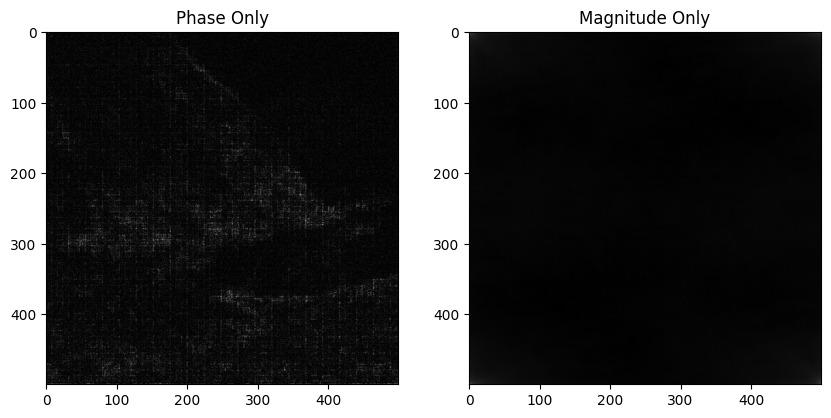

In [51]:
# D1. Phase-only reconstruction
# Normalizing by dividing by absolute value (Magnitude)
phase_only_comp = fshift / (np.abs(fshift) + 1e-8)  # added small epsilon to avoid div by zero
recon_phase = np.abs(np.fft.ifft2(np.fft.ifftshift(phase_only_comp)))

# D2. Magnitude-only reconstruction
# Here we just take the absolute values and ignore the phase

mag_only_comp = np.abs(fshift)
recon_mag = np.abs(np.fft.ifft2(np.fft.ifftshift(mag_only_comp)))

plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(recon_phase, cmap='gray'), plt.title("Phase Only")
plt.subplot(122), plt.imshow(recon_mag, cmap='gray'), plt.title("Magnitude Only")
plt.show()

# np.angle gives radians, which is just the 'value' of the phase.
# But the code line (fshift / abs) keeps the complex direction, which is essentially Magnitude=1 and Phase=original. The log in the spectrum is for visualization only—it makes small values visible by squashing the massive DC spike.

## Bonus - Part E

Load another image as you did before. Then swap magnitude and phase between them. In other words, for both images, find the magnitudes and phases. Combine magnitude of image 1 with phase of image 2. Also combine magnitude of 2 with phase of 1. Then reconstruct and display the resultant images.

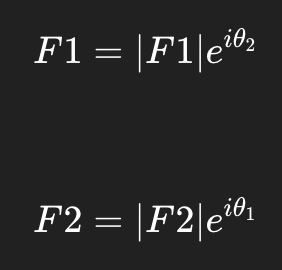

Do you notice how phase describes structure and magnitude describes texture of image ? Mention at last in code comments.


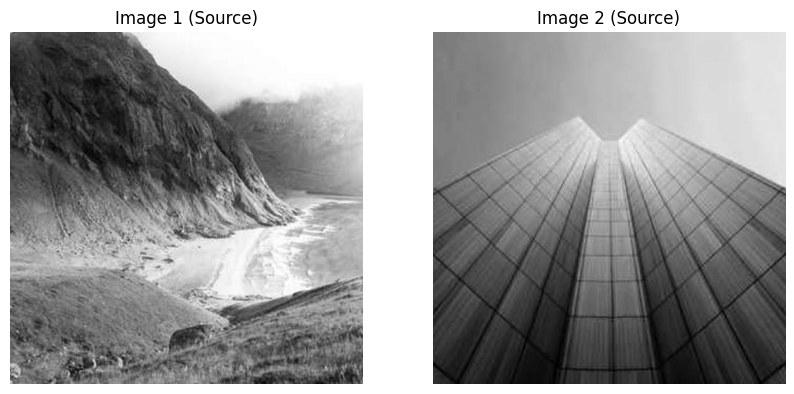

In [52]:
#  Previewing the two images for the swap

# Fetching a second image
img2_raw = download_image(505)
img2_gray = cv2.cvtColor(img2_raw, cv2.COLOR_BGR2GRAY)

# Displaying both
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray_manual, cmap='gray')
plt.title("Image 1 (Source)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_gray, cmap='gray')
plt.title("Image 2 (Source)")
plt.axis('off')

plt.show()

In [53]:
# Performing the actual swap

# 1. Get the Fourier Transforms
F1 = np.fft.fft2(gray_manual)
F2 = np.fft.fft2(img2_gray)

# 2. Extract Magnitude and Phase
mag1, phase1 = np.abs(F1), np.angle(F1)
mag2, phase2 = np.abs(F2), np.angle(F2)

# 3. Reconstruct using Euler's formula: F = Mag * exp(j * Phase)
# Combination 1: Mag of Img 1 + Phase of Img 2
hybrid_a_freq = mag1 * np.exp(1j * phase2)
hybrid_a_img = np.abs(np.fft.ifft2(hybrid_a_freq))

# Combination 2: Mag of Img 2 + Phase of Img 1
hybrid_b_freq = mag2 * np.exp(1j * phase1)
hybrid_b_img = np.abs(np.fft.ifft2(hybrid_b_freq))

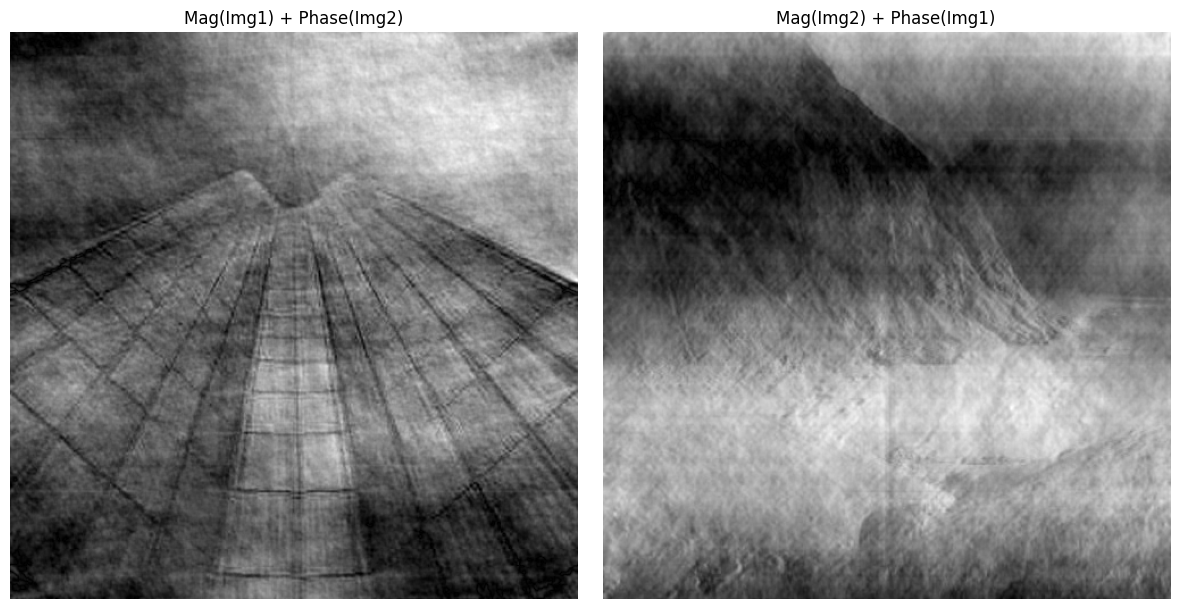

In [54]:
# Displaying results

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(hybrid_a_img, cmap='gray')
plt.title("Mag(Img1) + Phase(Img2)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hybrid_b_img, cmap='gray')
plt.title("Mag(Img2) + Phase(Img1)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Even though the Magnitude (the energy) came from one image, the resulting 'Hybrid' almost entirely looks like the imagethat provided the phase.
 # This is a classic computer vision demo showing that Phase carries the critical 'spatial' information (where the edges are), while Magnitude carries the 'frequency' information (overall contrast and how much detail exists in the textures).